# Decision Analysis and Policy Evaluation

Up to this point, the analysis has focused on validating the predictive models from a statistical and behavioral perspective — including discrimination, calibration, interpretability, stability over time, and segment-level error analysis. Having established that the models behave in a consistent and sensible way, the purpose of this notebook is to shift the focus from model quality to decision impact. In other words, we now explore how model scores translate into concrete credit decisions and what trade-offs emerge when those scores are used to define approval policies.

This notebook will explore how approval rates, risk concentration, and loss proxies shift as we adjust score cut-offs, helping us understand how the portfolio’s composition changes when criteria are tightened or relaxed. Rather than making claims about absolute profitability or optimal decisions, the focus is on comparing how risk levels and volume distribution vary across score ranges and how different models behave when applied to the same approval context.

To begin, we’ll examine the dataset to interpret the decision policy currently implemented by the company. Applicant risk segmentation is based on the `loan_grade` and `loan_subgrade` features. By analyzing these groups, we can observe patterns in average loan amounts, interest rates, and the share of approved applicants across different risk bands.

For example, a much smaller population in the riskiest subgrades might point to stricter approval rules for high-risk applicants, even if these individuals are offered higher interest rates. On the other hand, seeing higher volumes or relatively favorable rates in certain subgrades could signal a targeted risk appetite or strategic business positioning. This analysis enables us to infer the logic of approval strategies, risk-based pricing patterns, and business rules that define the current lending approach. It also highlights whether the acceptance policy is applied consistently or if there is special caution in specific segments. Building on these insights, we can later link observed patterns to model-predicted scores and simulate the impact of changing approval policy.

In [42]:
import sys
sys.path.append("..")

import pandas as pd
from functions import performance_report, default_report

In [43]:
TARGET = "default_binary"
XGB_SCORE_COLUMN = "xgb_pred_calibrated"
LR_SCORE_COLUMN = "lr_pred_calibrated"

data = pd.read_parquet("../data/scored_calibrated_data.parquet")

validation_data = data[data["dataset"] == "validation"]

In [44]:
with pd.option_context('display.max_columns', None):
    summary = validation_data.groupby('loan_grade')[['default_binary', 'loan_amount_funded', 'interest_rate']].mean()
    summary['count'] = validation_data.groupby('loan_grade').size()
    summary['default_binary'] = summary['default_binary'].map(lambda x: f"{x:.1%}")
    summary['interest_rate'] = summary['interest_rate'].map(lambda x: f"{x:.1%}")
    summary['loan_amount_funded'] = summary['loan_amount_funded'].map(lambda x: f"${x:,.0f}")

    display(summary.T)

    summary = validation_data.groupby('loan_subgrade')[['default_binary', 'loan_amount_funded', 'interest_rate']].mean()
    summary['count'] = validation_data.groupby('loan_subgrade').size()
    summary['default_binary'] = summary['default_binary'].map(lambda x: f"{x:.1%}")
    summary['interest_rate'] = summary['interest_rate'].map(lambda x: f"{x:.1%}")
    summary['loan_amount_funded'] = summary['loan_amount_funded'].map(lambda x: f"${x:,.0f}")

    display(summary.T)

loan_grade,A,B,C,D,E,F,G
default_binary,4.6%,11.0%,18.5%,24.7%,29.0%,36.0%,38.6%
loan_amount_funded,"$13,918","$12,068","$12,370","$14,311","$13,173","$13,256","$17,279"
interest_rate,6.9%,10.5%,14.0%,18.2%,24.1%,29.4%,30.9%
count,10033,17051,13566,5328,1581,286,57


loan_subgrade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
default_binary,2.6%,4.2%,5.1%,5.2%,6.6%,8.6%,9.1%,11.2%,11.8%,13.6%,16.7%,17.8%,18.6%,20.1%,20.7%,23.5%,23.6%,24.6%,28.3%,41.0%,27.7%,29.1%,27.1%,30.0%,36.1%,33.3%,36.8%,30.8%,48.5%,41.4%,20.0%,33.3%,33.3%,100.0%,64.3%
loan_amount_funded,"$13,743","$13,822","$14,429","$14,743","$13,130","$12,479","$12,222","$11,814","$11,788","$11,955","$11,967","$11,754","$11,753","$13,474","$13,217","$14,016","$14,532","$14,793","$13,883","$13,864","$13,652","$13,085","$13,425","$11,474","$13,565","$12,342","$12,071","$12,442","$16,655","$16,667","$21,176","$12,556","$14,772","$19,450","$17,059"
interest_rate,5.3%,7.0%,7.2%,7.5%,8.0%,8.2%,10.5%,11.4%,11.4%,11.5%,12.7%,13.5%,14.0%,15.0%,16.0%,17.0%,18.0%,19.0%,20.0%,21.5%,22.7%,24.0%,24.7%,25.5%,26.2%,28.7%,29.5%,30.0%,30.5%,30.7%,30.8%,30.8%,30.9%,30.9%,31.0%
count,2727,1719,1625,1820,2142,4043,2631,2705,3096,4576,3828,2764,2272,2606,2096,1718,1570,1135,844,61,537,402,291,207,144,147,38,39,33,29,20,12,9,2,14


The grade and subgrade breakdown reveals a very clear and economically intuitive pattern. As we move from safer to riskier bands, default rates increase monotonically, and this increase is closely matched by a stepwise rise in the interest rates charged. This strongly suggests that the company is operating under a risk-based pricing framework, where higher expected risk is explicitly compensated through higher rates rather than being addressed solely via rejection. In other words, acceptance and pricing appear to be jointly optimized, not treated as independent decisions. Also, there does not appear to be a consistent shift in the approved loan amount across risk bands, as funded loan amounts remain fairly stable in the 13–14k range for all grades. This indicates that lending limits are not being systematically adjusted alongside risk or pricing.

At the same time, volume distribution across grades provides important additional context. While interest rates continue to increase in the riskiest grades and subgrades, the number of approved loans drops sharply in these regions. This indicates that pricing alone is not the only control mechanism: there is also a clear approval filter that limits exposure to the highest-risk applicants. The very small counts observed in the worst subgrades (particularly in F and G) suggest that these segments may be deliberately kept thin, either due to internal risk limits, regulatory considerations, or to maintain optionality for future policy adjustments without materially impacting portfolio performance.

Taken together, these patterns imply that the dataset is not generated at random, but rather reflects the outcome of an existing credit policy that combines selective approval with risk-adjusted pricing. This is an expected and realistic feature of real-world lending data, but it has important implications for modeling and evaluation: observed outcomes in the highest risk bands are conditional on having already passed a policy filter. As a next step, we can explicitly connect this inferred policy structure to model scores by mapping predicted risk to grades, simulating alternative cut-offs, and assessing how approval rates, risk concentration, and score distributions would shift under different decision rules. This will allow us to move from descriptive policy inference to counterfactual policy analysis, which is ultimately where model value is realized.


TO DO: COMO FAZER

As a next step, we can explicitly connect this inferred policy structure to model scores by mapping predicted risk to grades, simulating alternative cut-offs, and assessing how approval rates, risk concentration, and score distributions would shift under different decision rules. This will allow us to move from descriptive policy inference to counterfactual policy analysis, which is ultimately where model value is realized.

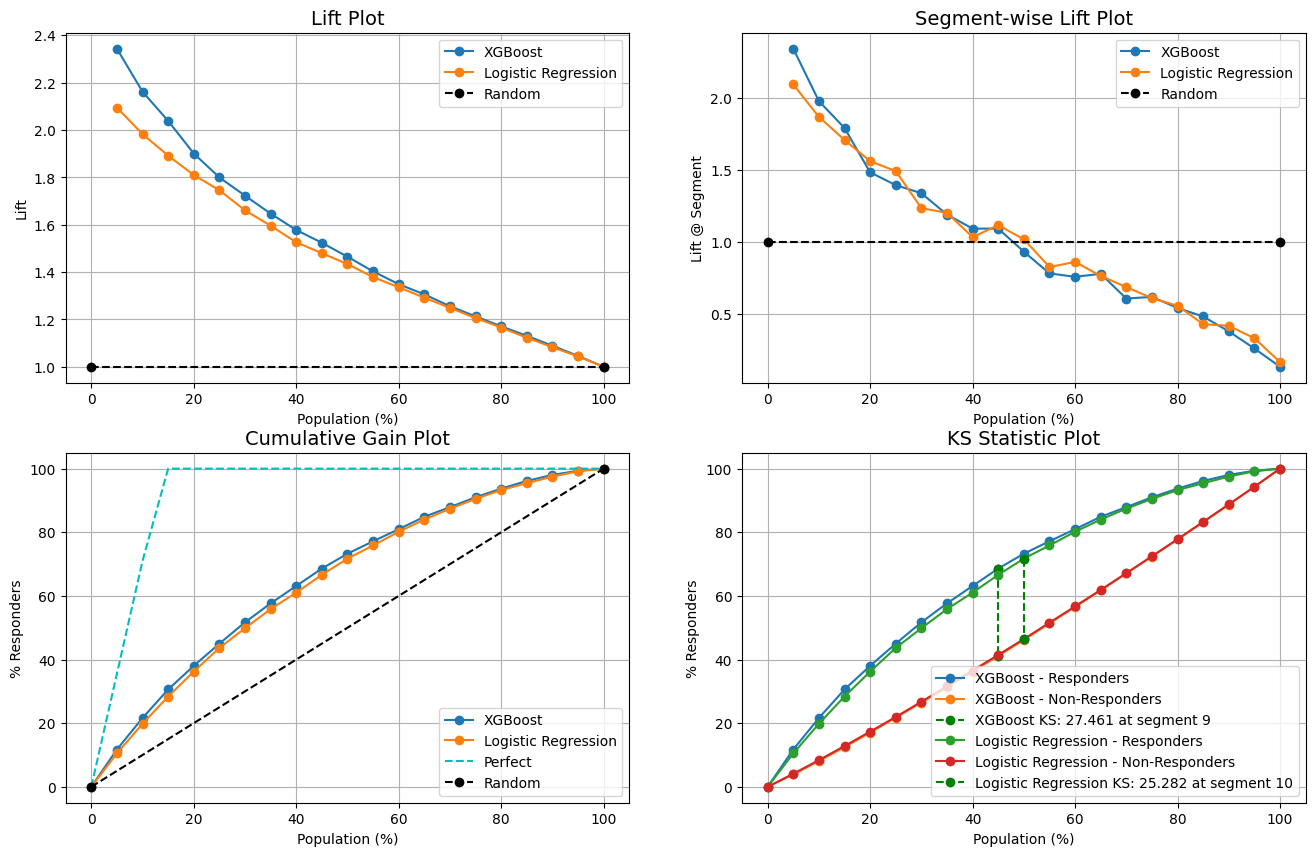

In [5]:
st = performance_report(validation_data[TARGET], {'XGBoost': validation_data[XGB_SCORE_COLUMN], 'Logistic Regression': validation_data[LR_SCORE_COLUMN]}, labels=False, n_segments=20)

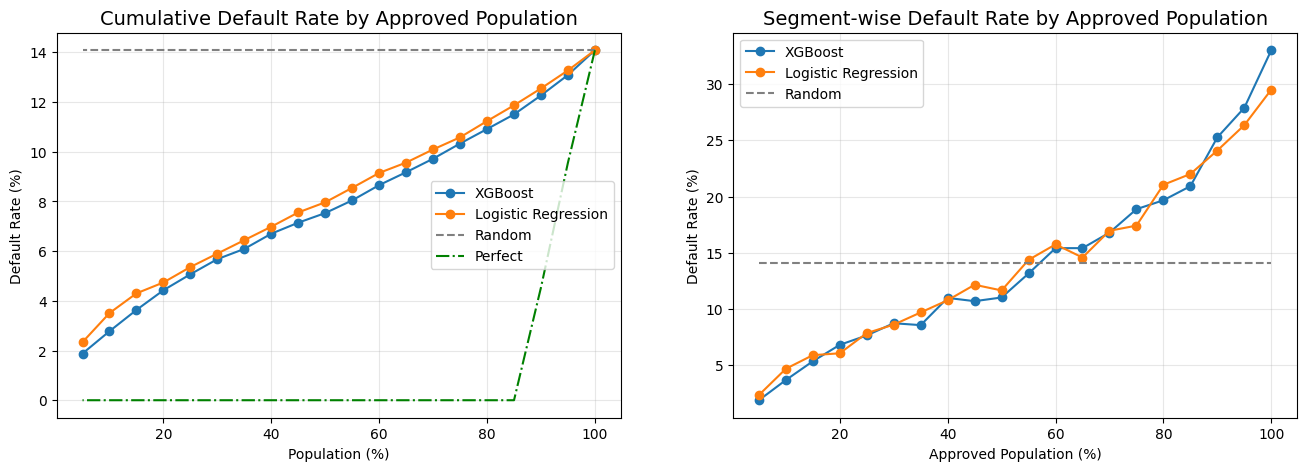

In [ ]:
aa = default_report(vd[TARGET], {'XGBoost': vd[XGB_SCORE_COLUMN], 'Logistic Regression': vd[LR_SCORE_COLUMN]}, labels=False, n_segments=20)

In [93]:
aa = cd['XGBoost']

aa[["cumulative_count_percentage_topdown", "cumulative_responders_rate", "cumulative_perfect_responders_rate", "cumulative_random_responders_rate"]]

,cumulative_count_percentage_topdown,cumulative_responders_rate,cumulative_perfect_responders_rate,cumulative_random_responders_rate
0,100.000000,14.085007,14.085007,14.085007
1,94.998121,13.088384,9.561377,14.085007
2,89.998330,12.266011,4.537125,14.085007
3,84.998539,11.501621,0.000000,14.085007
4,79.998747,10.913076,0.000000,14.085007
5,74.998956,10.329566,0.000000,14.085007
6,69.999165,9.719364,0.000000,14.085007
7,64.999374,9.175874,0.000000,14.085007
8,59.999582,8.656623,0.000000,14.085007
9,54.999791,8.042967,0.000000,14.085007


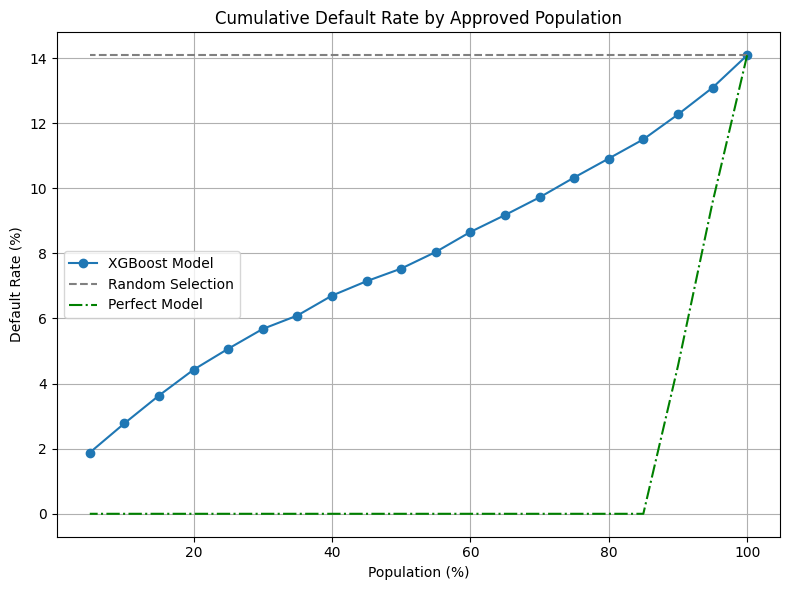

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(
    aa["cumulative_count_percentage_topdown"],
    aa["cumulative_responders_rate"],
    marker='o',
    label="XGBoost Model"
)

plt.plot(
    aa["cumulative_count_percentage_topdown"],
    aa["cumulative_random_responders_rate"],
    linestyle='--',
    color='gray',
    label="Random Selection"
)

plt.plot(
    aa["cumulative_count_percentage_topdown"],
    aa["cumulative_perfect_responders_rate"],
    linestyle='-.',
    color='green',
    label="Perfect Model"
)

plt.xlabel("Population (%)")
plt.ylabel("Default Rate (%)")
plt.title("Cumulative Default Rate by Approved Population")


plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

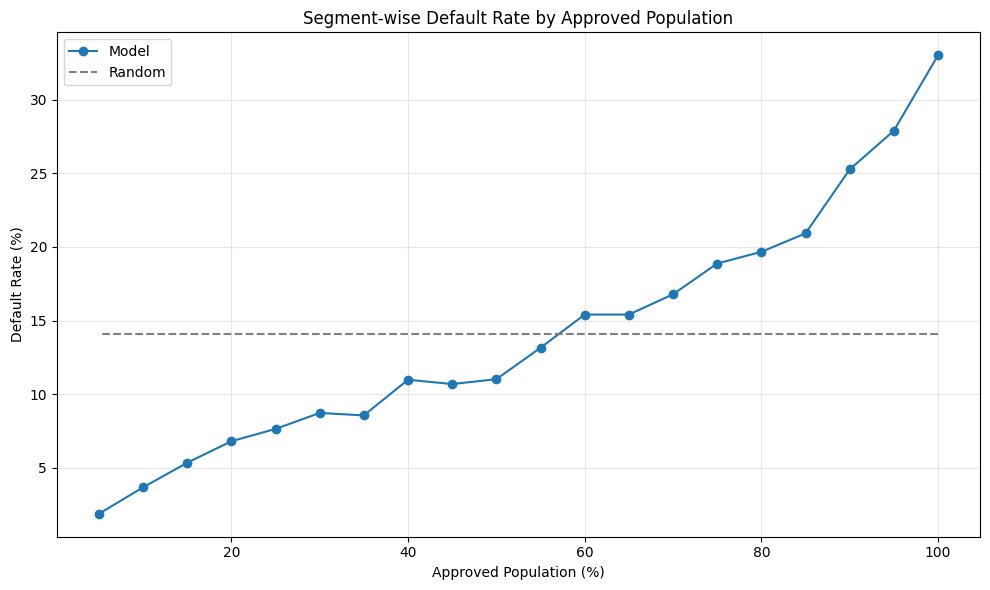

In [98]:
import numpy as np
import matplotlib.pyplot as plt

aa["segment_default_rate"] = aa["responders"] * 100 / aa["count"]
aa["segment_default_rate_random"] = aa["responders"].sum() * 100 / aa["count"].sum()

x = aa["cumulative_count_percentage_topdown"]

plt.figure(figsize=(10, 6))
plt.plot(x, aa["segment_default_rate"], marker="o", label="Model")
plt.plot(x, aa["segment_default_rate_random"], linestyle="--", color="gray", label="Random")

plt.xlabel("Approved Population (%)")
plt.ylabel("Default Rate (%)")
plt.title("Segment-wise Default Rate by Approved Population")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
aa_aug.tail()

,cumulative_count_percentage,cumulative_responders_percentage,cumulative_perfect_responders_percentage,segment,probability_min,probability_max,probability_average,count,responders,non_responders,expected_responders_random,expected_responders_perfect,response_rate,cumulative_count,cumulative_responders,cumulative_perfect_responders,cumulative_non_responders,cumulative_non_responders_percentage,ks_statistic,lift
16,80.001,93.716,100.0,16.0,0.064,0.068,0.068,2395.0,183.0,2212.0,337.35,0.0,7.641,38322.0,6323.0,6747.0,31999.0,77.752,15.963,1.171
17,85.001,96.132,100.0,17.0,0.055,0.064,0.056,2395.0,163.0,2232.0,337.35,0.0,6.806,40717.0,6486.0,6747.0,34231.0,83.176,12.956,1.131
18,90.000,98.029,100.0,18.0,0.045,0.055,0.050,2395.0,128.0,2267.0,337.35,0.0,5.344,43112.0,6614.0,6747.0,36498.0,88.684,9.345,1.089
19,95.000,99.333,100.0,19.0,0.024,0.045,0.038,2395.0,88.0,2307.0,337.35,0.0,3.674,45507.0,6702.0,6747.0,38805.0,94.290,5.043,1.046
20,100.000,100.000,100.0,20.0,0.020,0.024,0.022,2395.0,45.0,2350.0,337.35,0.0,1.879,47902.0,6747.0,6747.0,41155.0,100.000,0.000,1.000


Both models shows strong discriminatory power, with a clear monotonic decrease in observed default rates across score deciles and a KS around 27, which is solid for unsecured credit. The top deciles concentrate a disproportionate share of defaults, delivering meaningful lift over random selection. Calibration also appears very tight at the decile level, with predicted probabilities closely matching observed default rates across the score range. That said, given how clean the alignment is, we should double-check that calibration was assessed strictly out-of-sample, as in-sample or post-calibration evaluation can make reliability look deceptively perfect.

In [ ]:
10

In [ ]:
# Standard library
from pathlib import Path
import sys

# IPython/Jupyter-related imports
from IPython.display import display

# Core scientific and data analysis libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import roc_auc_score

sys.path.append("..");
from functions import decile_table, report

sns.set_theme(style="whitegrid")
pd.options.display.max_rows = 20

In [ ]:
DATA_PATH = Path("..") / "data" / "scored_data.parquet"
assert DATA_PATH.exists(), "Run previous notebooks to generate scored_data.parquet"

data = pd.read_parquet(DATA_PATH)

train_data = data[data["dataset"] == "train"].copy()
calibration_data = data[data["dataset"] == "calibration"].copy()
validation_data = data[data["dataset"] == "validation"].copy()

TARGET = "default_binary"
XGB_SCORE_COLUMN = "xgb_pred"
LR_SCORE_COLUMN = "lr_pred"

print(data[["dataset"]].value_counts().rename_axis("dataset").reset_index(name="count"))
print({"validation_default_rate": validation_data[TARGET].mean(), "validation_size": len(validation_data)})

# 1. Context and Decision Framing
- Objetivo da política: aprovação, risco, retorno esperado.
- Limitações do modelo atual: black box, pontos desconhecidos.
- Comentário sênior típico: "At this stage, we are not claiming incremental profit, only demonstrating the risk-ranking and segmentation capabilities of the model under simplifying assumptions."

# 2. Estratificação de Risco por Faixas de Score
- Uso de decis (10 faixas) para segmentar o score do XGB.
- Default rate por faixa, volume de propostas e captura acumulada de risco.

In [ ]:
SEGMENTS = 10
score_column = XGB_SCORE_COLUMN

validation_scores = validation_data[[TARGET, score_column, "loan_amount_funded"]].copy()
validation_scores["score_rank"] = validation_scores[score_column].rank(method="first", ascending=False)
validation_scores["score_band"] = pd.qcut(
    validation_scores["score_rank"], q=SEGMENTS, labels=False
) + 1

risk_bands = (
    validation_scores
    .groupby("score_band")
    .agg(
        proposals=("loan_amount_funded", "size"),
        defaults=(TARGET, "sum"),
        default_rate=(TARGET, "mean"),
        average_score=(score_column, "mean"),
        exposure=("loan_amount_funded", "sum"),
    )
    .sort_index()
)

risk_bands["approval_share"] = risk_bands["proposals"] / risk_bands["proposals"].sum()
risk_bands["cumulative_approval_share"] = risk_bands["approval_share"].cumsum()

total_defaults = risk_bands["defaults"].sum()
risk_bands["cumulative_default_capture"] = (
    risk_bands["defaults"].cumsum() / total_defaults if total_defaults > 0 else np.nan
)

risk_bands["exposure_share"] = risk_bands["exposure"] / risk_bands["exposure"].sum()
risk_bands["cumulative_exposure_share"] = risk_bands["exposure_share"].cumsum()

display(risk_bands)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=risk_bands.reset_index(),
    x="score_band",
    y="default_rate",
    ax=axes[0],
    color="#4C72B0",
)
axes[0].set_xlabel("Decil (1 = maior risco)")
axes[0].set_ylabel("Taxa de default")
axes[0].set_title("Default rate por decil")

axes[1].plot(
    risk_bands.index,
    risk_bands["cumulative_default_capture"],
    marker="o",
    label="Captura acumulada de risco",
)
axes[1].plot(
    risk_bands.index,
    risk_bands["cumulative_approval_share"],
    marker="o",
    label="Aprovação acumulada",
)
axes[1].plot(
    risk_bands.index,
    risk_bands["cumulative_exposure_share"],
    marker="o",
    label="Exposição acumulada",
)
axes[1].set_xlabel("Decil (1 = maior risco)")
axes[1].set_ylabel("Proporção acumulada")
axes[1].set_ylim(0, 1.05)
axes[1].legend()
axes[1].set_title("Captura acumulada vs. aprovação")

plt.tight_layout()

# 3. Análise de Lift e KS
- Lift acumulado por segmento e curva KS.
- Comparação entre modelos apenas pelo ranking (XGB vs LR).

In [ ]:
y_val = validation_data[TARGET].to_numpy()
xgb_scores = validation_data[XGB_SCORE_COLUMN].to_numpy()
lr_scores = validation_data[LR_SCORE_COLUMN].to_numpy()

xgb_deciles = decile_table(y_val, xgb_scores, change_deciles=10, labels=False)
lr_deciles = decile_table(y_val, lr_scores, change_deciles=10, labels=False)

def top_default_capture(decile_df, top_n=2):
    return decile_df[decile_df["decile"] <= top_n]["responders"].sum() / decile_df["responders"].sum()

ranking = (
    pd.DataFrame(
        [
            {
                "model": "XGBoost",
                "roc_auc": roc_auc_score(y_val, xgb_scores),
                "ks": xgb_deciles["ks_statistic"].max(),
                "top2_default_capture": top_default_capture(xgb_deciles),
            },
            {
                "model": "Logistic Regression",
                "roc_auc": roc_auc_score(y_val, lr_scores),
                "ks": lr_deciles["ks_statistic"].max(),
                "top2_default_capture": top_default_capture(lr_deciles),
            },
        ]
    )
    .sort_values(by="roc_auc", ascending=False)
    .reset_index(drop=True)
)

display(ranking)

_ = report(
    y_val,
    xgb_scores,
    labels=False,
    title_fontsize=12,
    text_fontsize=10,
    figsize=(12, 8),
)
plt.suptitle("Lift e KS - XGB", fontsize=14)
plt.tight_layout()

_ = report(
    y_val,
    lr_scores,
    labels=False,
    title_fontsize=12,
    text_fontsize=10,
    figsize=(12, 8),
)
plt.suptitle("Lift e KS - LR", fontsize=14)
plt.tight_layout()

# 4. Curvas de Perda Esperada (EL) e Aprovação
- EL = PD × Exposure (assumindo LGD fixa) e relação com a taxa de aprovação.
- Apresentação dos trade-offs considerando aprovação, perda esperada e custos.

In [ ]:
LGD_ASSUMPTION = 1.0
threshold_grid = [0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.20]
rows = []

for thr in threshold_grid:
    approved = validation_data[validation_data[XGB_SCORE_COLUMN] <= thr]
    exposure = approved["loan_amount_funded"].sum()
    expected_loss = (
        approved[XGB_SCORE_COLUMN] * approved["loan_amount_funded"] * LGD_ASSUMPTION
    ).sum()
    rows.append(
        {
            "threshold": thr,
            "approval_rate": len(approved) / len(validation_data),
            "portfolio_default_rate": approved[TARGET].mean(),
            "expected_loss_pct_of_exposure": expected_loss / exposure if exposure > 0 else np.nan,
            "expected_loss_total": expected_loss,
            "avg_exposure": approved["loan_amount_funded"].mean(),
            "total_exposure": exposure,
        }
    )

threshold_table = pd.DataFrame(rows).sort_values(by="threshold")

display(threshold_table)

fig, axis = plt.subplots(figsize=(7, 5))
sns.lineplot(
    data=threshold_table,
    x="approval_rate",
    y="expected_loss_pct_of_exposure",
    marker="o",
    ax=axis,
)
axis.set_xlabel("Taxa de aprovação")
axis.set_ylabel("Perda esperada / exposição")
axis.set_title("Aprovação vs perda esperada")
plt.tight_layout()

# 5. Cutoffs Candidatos
- Cenários conservadores vs. agressivos e sensibilidade a pequenas mudanças.
- Robustez em relação a possíveis erros de calibração.

In [ ]:
candidate_cutoffs = {
    "conservador": 0.09,
    "balanceado": 0.11,
    "agressivo": 0.15,
}

scenario_rows = []
for scenario, thr in candidate_cutoffs.items():
    matched = threshold_table[threshold_table["threshold"] == thr]
    if not matched.empty:
        base = matched.iloc[0].to_dict()
    else:
        approved = validation_data[validation_data[XGB_SCORE_COLUMN] <= thr]
        exposure = approved["loan_amount_funded"].sum()
        expected_loss = (
            approved[XGB_SCORE_COLUMN] * approved["loan_amount_funded"] * LGD_ASSUMPTION
        ).sum()
        base = {
            "threshold": thr,
            "approval_rate": len(approved) / len(validation_data),
            "portfolio_default_rate": approved[TARGET].mean(),
            "expected_loss_pct_of_exposure": expected_loss / exposure if exposure > 0 else np.nan,
            "expected_loss_total": expected_loss,
            "avg_exposure": approved["loan_amount_funded"].mean(),
            "total_exposure": exposure,
        }
    base["scenario"] = scenario
    scenario_rows.append(base)

scenario_table = (
    pd.DataFrame(scenario_rows)
    .sort_values(by="threshold")
    .reset_index(drop=True)
)

scenario_table["approval_rate_delta_vs_prev"] = scenario_table["approval_rate"].diff()
scenario_table["expected_loss_pct_delta_vs_prev"] = scenario_table[
    "expected_loss_pct_of_exposure"
].diff()

display(
    scenario_table[
        [
            "scenario",
            "threshold",
            "approval_rate",
            "portfolio_default_rate",
            "expected_loss_pct_of_exposure",
            "approval_rate_delta_vs_prev",
            "expected_loss_pct_delta_vs_prev",
        ]
    ]
)

# 6. Premissas e Limitações
- LGD considerada constante e simplificada.
- Modelo de pricing/limite fixo e não otimizado neste estágio.
- Sample selection: modelo atual já rejeita alguns usuários.
- Revisar calibração antes da decisão final para evitar distorções próximas ao cutoff.